# Noise Map
## ISO 9613-2: Calculation of Noise from Wind Turbines

ISO 9613-2 is an international standard that provides guidelines for the calculation of outdoor sound propagation from industrial sources, including wind turbines {cite:p}`iso_9613`. It specifically focuses on the prediction of sound levels over extended distances in outdoor environments.

To generate noise calculations using ISO 9613-2 in a Jupyter Notebook, you would typically follow these steps:

1. **Data Collection**: Gather the necessary information about the wind turbines and their surroundings. This includes parameters such as the turbine specifications (e.g., sound power level, rotor diameter, hub height), site topography, ground characteristics, atmospheric conditions, and receiver locations.

2. **Source Modeling**: Determine the sound power level of the wind turbines. This information is usually provided by the turbine manufacturer or can be measured on-site. The sound power level represents the acoustic power emitted by the turbine.

3. **Propagation Modeling**: Apply ISO 9613-2 guidelines to predict how the sound propagates from the turbines to the receiver locations. The standard uses a mathematical model that takes into account factors such as atmospheric absorption, ground attenuation, meteorological conditions, and geometric spreading of sound waves.

4. **Calculation Procedure**: Implement the ISO 9613-2 equations in your Jupyter Notebook. These equations involve various calculations, including the determination of sound pressure levels at different receiver locations based on the source modeling, propagation modeling, and other parameters.

5. **Output Visualization**: Once the calculations are performed, you can visualize the results to generate a noise map. This can be achieved by plotting the predicted sound levels on a map using appropriate visualization techniques. The noise map provides a spatial representation of the sound levels in the vicinity of the turbines.

It is important to note that ISO 9613-2 provides standardized procedures for noise prediction, but the accuracy of the predictions can be influenced by various factors, such as local conditions and the assumptions made during the modeling process. Therefore, it is crucial to carefully consider the input data and model limitations when using ISO 9613-2 for noise calculations.

[^iso9613-2]: International Organization for Standardization. (1996). ISO 9613-2:1996, Acoustics - Attenuation of sound during propagation outdoors - Part 2: General method of calculation. Geneva, Switzerland: International Organization for Standardization.

In [1]:
%matplotlib inline
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import ElevationHandler, ElevationHandlerTest, import_point_source_data, calc_extent, solve_noise_map
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LogNorm
from pyproj import Geod
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs
import pandas as pd

In [2]:
# map_boundaries = [11.9, 12.1, 54.9, 55.1]
# dist = 1500
# point_source_data = import_point_source_data("Prøvestenen.json")
# map_boundaries = calc_extent(point_source_data, dist)
# # map_boundaries = [0, 210, 0, 210]
map_shape = [50, 50]
# elevation_handler = ElevationHandler(map_boundaries, map_shape)
# elevation_handler = ElevationHandlerTest(map_boundaries, map_shape)


point_source_data = pd.DataFrame(data = [{"latitude": 55.672127553476294,
        "longitude": 12.638808914018623,
        "h": 80,
        "octave_band": {"1000": 104.0}}])

map_shape = [50, 50]
dist = 1500
map_boundaries = calc_extent(point_source_data, dist)
elevation_handler = ElevationHandler(map_boundaries, map_shape)
LDW = solve_noise_map(elevation_handler, point_source_data)

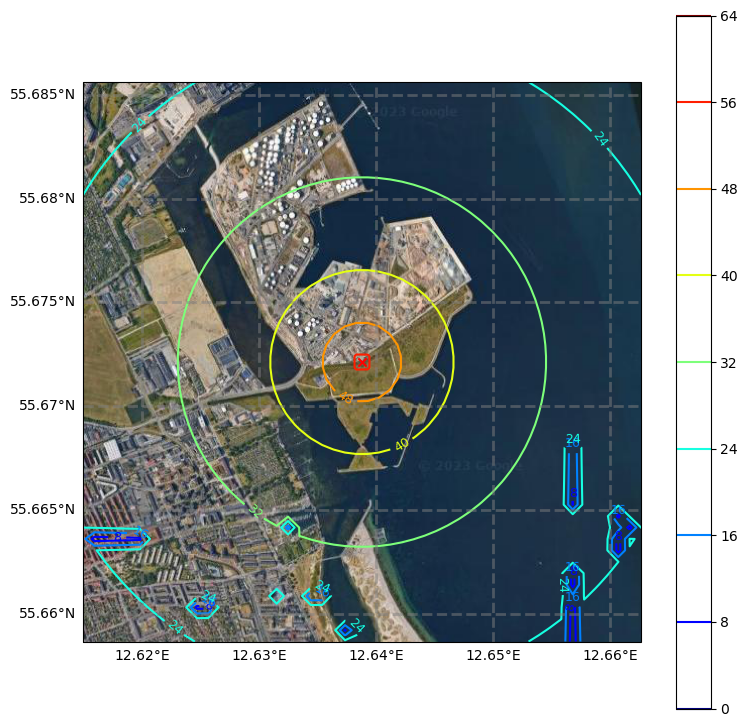

In [3]:
plt.figure(figsize=(9, 9))
imagery = GoogleTiles(style = "satellite")
ax = plt.axes(projection=imagery.crs)
ax.set_extent(map_boundaries)

cp = ax.contour(elevation_handler.long_range, elevation_handler.lat_range, LDW, alpha = 1, cmap = "jet", transform=ccrs.PlateCarree())
ax.scatter(point_source_data.longitude, point_source_data.latitude, marker = "x", color = "red", transform=ccrs.PlateCarree())
plt.colorbar(cp, ax = ax)
plt.clabel(cp, fontsize = 9, inline=1)

ax.add_image(imagery, 14) # 16
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.tight_layout
plt.show()


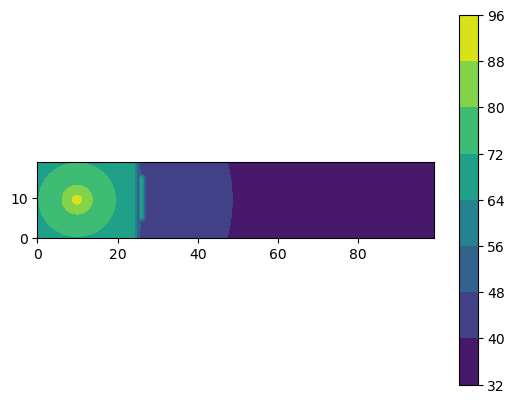

In [6]:
point_source_data = import_point_source_data("Test.json")
map_shape = [20, 100]
map_array = np.zeros(map_shape)
map_array[:,25] = 100
elevation_handler = ElevationHandlerTest(map_array)
LDW = solve_noise_map(elevation_handler, point_source_data)

fig, ax = plt.subplots()
cl = ax.contourf(LDW)
plt.colorbar(cl, ax = ax)
ax.set(aspect="equal")
plt.tight_layout
plt.show()